<a href="https://colab.research.google.com/github/AtulyaMS/dotfiles/blob/master/FinalModel_TrainingPro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress=True)

In [ ]:
# import SimpleITK as sitk


# from dltk.io import preprocessing
# from skimage import filters

# from nipype.interfaces import fsl
# from nipype.interfaces.fsl import BET
# from nipype.testing import example_data



In [46]:
import shutil
import tensorflow as tf
import os
import gzip
import tarfile

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns


In [49]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from sklearn.model_selection import cross_val_predict, train_test_split
import scikitplot as skplt
from sklearn.metrics import classification_report

In [3]:
IMG_SHAPE = (78, 110, 86)
IMG_2D_SHAPE = (IMG_SHAPE[1] * 4, IMG_SHAPE[2] * 4)
#SHUFFLE_BUFFER = 5 #Subject to change
N_CLASSES = 3

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [5]:
root_dir = "/content/gdrive/MyDrive/"
base_dir = root_dir + 'Final_model_training'
os.chdir(base_dir)

In [6]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0]):
    ''' This function resamples images to 2-mm isotropic voxels.
      
        Parameters:
            itk_image -- Image in simpleitk format, not a numpy array
            out_spacing -- Space representation of each voxel
            
        Returns: 
            Resulting image in simpleitk format, not a numpy array
    '''
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [7]:
def registrate(sitk_fixed, sitk_moving, bspline=False):
    ''' Perform image registration using SimpleElastix.
        By default, uses affine transformation.
        
        Parameters:
            sitk_fixed -- Reference atlas (sitk .nii)
            sitk_moving -- Image to be registrated
                           (sitk .nii)
            bspline -- Whether or not to perform non-rigid
                       registration. Note: it usually deforms
                       the images and increases execution times
    '''
    
    elastixImageFilter = sitk.ElastixImageFilter()#sitk.ElastixImageFilter()   SimpleElastix()
    elastixImageFilter.SetFixedImage(sitk_fixed)
    elastixImageFilter.SetMovingImage(sitk_moving)

    parameterMapVector = sitk.VectorOfParameterMap()
    parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
    if bspline:
        parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    elastixImageFilter.Execute()
    return elastixImageFilter.GetResultImage()

In [8]:
def skull_strip_nii(original_img, destination_img, frac=0.2): #
    ''' Practice skull stripping on the given image, and save
        the result to a new .nii image.
        Uses FSL-BET 
        (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide#Main_bet2_options:)
        
        Parameters:
            original_img -- Original nii image
            destination_img -- The new skull-stripped image
            frac -- Fractional intensity threshold for BET
    '''
    
    btr = fsl.BET()
    btr.inputs.in_file = original_img
    btr.inputs.frac = frac
    btr.inputs.out_file = destination_img
    btr.cmdline
    res = btr.run()
    return res

In [9]:
def slices_matrix_2D(img):
  ''' Transform a 3D MRI image into a 2D image, by obtaining 9 slices 
      and placing them in a 4x4 two-dimensional grid.
      
      All 16 cuts are from a horizontal/axial view. They are selected
      from the 30th to the 60th level of the original 3D image.
      
      Parameters:
        img -- np.ndarray with the 3D image
        
      Returns:
        np.ndarray -- The resulting 2D image
  '''
  
  # create the final 2D image 
  image_2D = np.empty(IMG_2D_SHAPE)
  
  # set the limits and the step
  TOP = 60
  BOTTOM = 30
  STEP = 2
  N_CUTS = 16
  
  # iterator for the cuts
  cut_it = TOP
  # iterator for the rows of the 2D final image
  row_it = 0
  # iterator for the columns of the 2D final image
  col_it = 0
  
  for cutting_time in range(N_CUTS):
    
    # cut
    cut = img[cut_it, :, :]
    cut_it -= STEP
    
    # reset the row iterator and move the
    # col iterator when needed
    if cutting_time in [4, 8, 12]:
      row_it = 0
      col_it += cut.shape[1]
    
    # copy the cut to the 2D image
    for i in range(cut.shape[0]):
      for j in range(cut.shape[1]):
        image_2D[i + row_it, j + col_it] = cut[i, j]
    row_it += cut.shape[0]
  
  # return the final 2D image, with 3 channels
  # this is necessary for working with most pre-trained nets
  return np.repeat(image_2D[None, ...], 3, axis=0).T

In [10]:
def load_image_2D(abs_path): #, labels
  ''' Load an image (.nii) and its label, from its absolute path.
      Transform it into a 2D image, by obtaining 16 slices and placing them
      in a 4x4 two-dimensional grid.
      
      Parameters:
        abs_path -- Absolute path, filename included
        labels -- Label mapper
        
      Returns:
        img -- The .nii image, converted into a numpy array
        label -- The label of the image (from argument 'labels')
        
  '''
  
  # obtain the label from the path (it is the last directory name)
  #label = labels[abs_path.split('/')[-2]]
  
  # load the image with SimpleITK
  sitk_image = sitk.ReadImage(abs_path)
  
  # transform into a numpy array
  img = sitk.GetArrayFromImage(sitk_image)
  
  # apply whitening
  img = preprocessing.whitening(img)
  
  # make the 2D image
  img = slices_matrix_2D(img)
  
  return img

In [11]:
def gz_extract(zipfile):
    file_name = (os.path.basename(zipfile)).rsplit('.',1)[0] #get file name for file within
    with gzip.open(zipfile,"rb") as f_in, open(f"{zipfile.split('/')[0]}/{file_name}","wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    os.remove(zipfile) # delete zipped file
    # return f"{zipfile.split('/')[0]}/{file_name}"

In [12]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [13]:
def write_tfrecords(x, y, filename):
    writer = tf.io.TFRecordWriter(filename)

    for image, label in zip(x, y):
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'image': _bytes_feature(serialize_array(image)), #tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.tobytes()])),
                'label': _int64_feature(label) #tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }))
        writer.write(example.SerializeToString())


In [14]:
def _parse_image_function(example_proto):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.parse_tensor(features['image'], out_type=tf.double) #tf.io.decode_raw(features['image'], tf.float32) 
   # image.set_shape([3 * 344 * 440])
    image = tf.reshape(image, [344, 440, 3])

    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(features['label'], 3)

    return image, label

In [15]:
def read_dataset(epochs, batch_size, filename):

    # filenames = [os.path.join(channel, channel_name + '.tfrecords')]
    dataset = tf.data.TFRecordDataset(filename)

    dataset = dataset.map(_parse_image_function, num_parallel_calls=10)
    dataset = dataset.shuffle(buffer_size=10 * batch_size)               ##1
    dataset = dataset.repeat(epochs)                                     ##2
    dataset = dataset.batch(batch_size, drop_remainder=True)             ##3
    dataset = dataset.prefetch(batch_size)                               ##4

    return dataset

In [ ]:
categories = ['CN', 'MCI', 'AD']
category_dict = {'CN':0, 'MCI':1, 'AD':2}
nifti_files = []
labels = []

newpath = f"./Nifti_files/"
for category in categories:
    path = f"./{category}/"   
# r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.nii' in file:
                nifti_files.append(os.path.join(r, file))
                label = category_dict[category]#0 if category=='CN' else 1 if category=='MCI' else 2
                labels.append(label)
                
print(nifti_files[0:5])
print(labels[0:5])

[]
[]


In [ ]:
atlas = sitk.ReadImage('average305_t1_tal_lin_mask.nii')
atlas = resample_img(atlas)

In [ ]:
atlas_array = sitk.GetArrayFromImage(atlas)
plt.imshow(atlas_array[:, :, 70], cmap='gray')
plt.show()

In [ ]:
#res = resample_img(nifti_files[0], out_spacing=[2.0, 2.0, 2.0])

for image in nifti_files:
    sitk_image = sitk.ReadImage(image)
# transform into a numpy array
    sitk_array = sitk.GetArrayFromImage(sitk_image)
    
    res_image = resample_img(sitk_image)
    res_array = sitk.GetArrayFromImage(res_image)
    res_array = preprocessing.resize_image_with_crop_or_pad(res_array, img_size=(128, 192, 192), mode='symmetric')
    res_array = preprocessing.whitening(res_array)
    
    registrated_image = registrate(atlas, res_image, bspline=False)
    sitk.WriteImage(registrated_image, f"Registrated/{image.split('/')[-1]}_registrated.nii")
    
    registrated_image = sitk.ReadImage(f"Registrated/{image.split('/')[-1]}_registrated.nii")
    registrated_array = sitk.GetArrayFromImage(registrated_image)
    
    skull_strip_nii(f"Registrated/{image.split('/')[-1]}_registrated.nii", f"Skull_Stripped/{image.split('/')[-1]}_stripped.nii", frac=0.2)
    gz_extract(f"Skull_Stripped/{image.split('/')[-1]}_stripped.nii.gz")



In [ ]:
ss_images = os.listdir('Skull_Stripped')

for image in ss_images:
    image_2d = load_image_2D(f"Skull_Stripped/{image}")
 #   print(image_2d.shape)
    np.save(f"Image_2d/{image.split('/')[-1]}_2d", image_2d)

In [16]:
image_array = []
label_array = []
train_array = ["CN_TRAIN_Image2D", "MCI_TRAIN_Image2D", "AD_TRAIN_Image2D"]

for folder in train_array:
  for filename in os.listdir(folder):
    if filename.endswith('.npy'):
      image_array.append(np.load(f"{folder}/{filename}")) 
      label_array.append(0 if 'CN' in folder else 1 if 'MCI' in folder else 2)
        
image_array = np.array(image_array)

In [ ]:
print(image_array.shape)
print(Counter(label_array).keys()) # equals to list(set(words))
print(Counter(label_array).values()) # counts the elements' frequency

(1264, 344, 440, 3)
dict_keys([0, 1, 2])
dict_values([481, 493, 290])


In [ ]:
write_tfrecords(image_array, label_array, "./train.tfrecords")

In [17]:
Train = read_dataset(10, 50, './train.tfrecords') #image_array.shape[0]

In [18]:
Train

<PrefetchDataset element_spec=(TensorSpec(shape=(50, 344, 440, 3), dtype=tf.float64, name=None), TensorSpec(shape=(50, 3), dtype=tf.float32, name=None))>

In [ ]:
image_val_array = []
label_val_array = []
val_array = ["CN_VAL_Image2D", "MCI_VAL_Image2D", "AD_VAL_Image2D"]

for folder in val_array:
  for filename in os.listdir(folder):
    if filename.endswith('.npy'):
      image_val_array.append(np.load(f"{folder}/{filename}")) 
      label_val_array.append(0 if 'CN' in folder else 1 if 'MCI' in folder else 2)
        
image_val_array = np.array(image_val_array)

In [ ]:
print(image_val_array.shape)
print(Counter(label_val_array).keys()) # equals to list(set(words))
print(Counter(label_val_array).values()) # counts the elements' frequency

(350, 344, 440, 3)
dict_keys([0, 1, 2])
dict_values([125, 154, 71])


In [ ]:
write_tfrecords(image_val_array, label_val_array, "./val.tfrecords")

In [19]:
Validation = read_dataset(10, 50, './val.tfrecords') #image_val_array.shape[0]

In [20]:
Validation

<PrefetchDataset element_spec=(TensorSpec(shape=(50, 344, 440, 3), dtype=tf.float64, name=None), TensorSpec(shape=(50, 3), dtype=tf.float32, name=None))>

In [38]:
image_test_array = []
label_test_array = []
test_array = ["CN_TEST_Image2D", "MCI_TEST_Image2D", "AD_TEST_Image2D"]

for folder in test_array:
  for filename in os.listdir(folder):
    if filename.endswith('.npy'):
      image_test_array.append(np.load(f"{folder}/{filename}")) 
      label_test_array.append(0 if 'CN' in folder else 1 if 'MCI' in folder else 2)
        
image_test_array = np.array(image_test_array)

In [ ]:
print(image_test_array.shape)
print(Counter(label_test_array).keys()) # equals to list(set(words))
print(Counter(label_test_array).values())

(437, 344, 440, 3)
dict_keys([0, 1, 2])
dict_values([139, 204, 94])


In [ ]:
write_tfrecords(image_test_array, label_test_array, "./test.tfrecords")

In [21]:
Test = read_dataset(10, 50, './test.tfrecords')

In [22]:
Test

<PrefetchDataset element_spec=(TensorSpec(shape=(50, 344, 440, 3), dtype=tf.float64, name=None), TensorSpec(shape=(50, 3), dtype=tf.float32, name=None))>

In [23]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(344, 440, 3), 
    weights='imagenet', 
    include_top=False,
    pooling='avg') #'max'
base_model.trainable = False

base_output = base_model.output
hidden_layer = tf.keras.layers.Dense(512, activation='relu')(base_output) #512 
#hl_reg = tf.keras.layers.Dropout(0.5)(hidden_layer) #


output_layer = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(hidden_layer)
inception_model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

# for layer in base_model.layers:
#     layer.trainable = False

# compile the model 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6) #0.0001

METRICS = [
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), #precision-recall curve
      tf.keras.metrics.CategoricalAccuracy(name='categorical accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),

]

inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=METRICS) #, 'recall'

87910968/87910968 [==============================] - 0s 0us/step


In [24]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 344, 440, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 171, 219, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 171, 219, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [25]:
inception_model.fit(Train, epochs=2, validation_data=Validation, verbose=1) #, batch_size=128

Epoch 1/2
252/252 [==============================] - 385s 1s/step - loss: 1.1886 - auc: 0.5627 - prc: 0.3881 - categorical accuracy: 0.3952 - precision: 0.4024 - recall: 0.0597 - val_loss: 1.0518 - val_auc: 0.6308 - val_prc: 0.4430 - val_categorical accuracy: 0.4371 - val_precision: 0.5750 - val_recall: 0.0657
Epoch 2/2
252/252 [==============================] - 383s 2s/step - loss: 1.0622 - auc: 0.6106 - prc: 0.4404 - categorical accuracy: 0.4232 - precision: 0.6040 - recall: 0.0655 - val_loss: 1.0412 - val_auc: 0.6396 - val_prc: 0.4531 - val_categorical accuracy: 0.4686 - val_precision: 0.5490 - val_recall: 0.0800


In [26]:
es = EarlyStopping(patience=5, restore_best_weights=True) #, monitor='val_loss'
history = inception_model.fit(Train, epochs=50, validation_data=Validation, verbose=1, callbacks=[es]) #, batch_size=128


Epoch 1/50
252/252 [==============================] - 369s 1s/step - loss: 1.0404 - auc: 0.6418 - prc: 0.4793 - categorical accuracy: 0.4539 - precision: 0.6405 - recall: 0.1114 - val_loss: 1.0188 - val_auc: 0.6693 - val_prc: 0.4937 - val_categorical accuracy: 0.4886 - val_precision: 0.5811 - val_recall: 0.1229
Epoch 2/50
252/252 [==============================] - 378s 1s/step - loss: 1.0222 - auc: 0.6592 - prc: 0.5030 - categorical accuracy: 0.4712 - precision: 0.6523 - recall: 0.1486 - val_loss: 1.0285 - val_auc: 0.6556 - val_prc: 0.4780 - val_categorical accuracy: 0.4743 - val_precision: 0.5182 - val_recall: 0.1629
Epoch 3/50
252/252 [==============================] - 370s 1s/step - loss: 1.0014 - auc: 0.6783 - prc: 0.5329 - categorical accuracy: 0.4913 - precision: 0.6801 - recall: 0.1895 - val_loss: 1.0251 - val_auc: 0.6671 - val_prc: 0.4895 - val_categorical accuracy: 0.5000 - val_precision: 0.5259 - val_recall: 0.2029
Epoch 4/50
252/252 [==============================] - 384s 2s

In [27]:
inception_model.save(base_dir+'/inception_model6.h5') 

In [28]:
inception_model.evaluate(Test)

87/87 [==============================] - 107s 1s/step - loss: 0.9825 - auc: 0.7154 - prc: 0.5643 - categorical accuracy: 0.5306 - precision: 0.6161 - recall: 0.3313


[0.9824559688568115,
 0.715408980846405,
 0.564335286617279,
 0.5305747389793396,
 0.6160752177238464,
 0.3312643766403198]

In [31]:
path = f"./"   
Hdf5_file = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.h5' in file:
            Hdf5_file.append(os.path.join(r, file))

In [32]:
Hdf5_file

['./inception_model1.h5', './inception_model2.h5', './inception_model6.h5']

In [33]:
def plot_metrics(history):
    with plt.style.context('seaborn-deep'):
        fig, ax = plt.subplots(1, 3, figsize=(15, 4))
        ## Plot Losses and Accuracies
        x_axis = np.arange(len(history.history['loss']))
        ax[0].set_title("Loss")
        ax[0].plot(x_axis, history.history['loss'], color="blue", linestyle=":", marker="X", label="Train Loss")
        ax[0].plot(x_axis, history.history['val_loss'], color="orange", linestyle="-", marker="X", label="Val Loss")
        ax[1].set_title("AUC")
        ax[1].plot(x_axis, history.history['auc'], color="blue", linestyle=":", marker="X", label="Train AUC")
        ax[1].plot(x_axis,
                   history.history['val_auc'],
                   color="orange",
                   linestyle="-",
                   marker="X",
                   label="Val AUC")
        ax[2].set_title("PRC")
        ax[2].plot(x_axis, history.history['prc'], color="blue", linestyle=":", marker="X", label="Train PRC")
        ax[2].plot(x_axis,
                   history.history['val_prc'],
                   color="orange",
                   linestyle="-",
                   marker="X",
                   label="Val PRC")
        ## Customization
        ax[0].grid(axis="x", linewidth=0.5)
        ax[0].grid(axis="y", linewidth=0.5)
        ax[0].legend()
        ax[1].grid(axis="x", linewidth=0.5)
        ax[1].grid(axis="y", linewidth=0.5)
        ax[1].legend()
        ax[2].grid(axis="x", linewidth=0.5)
        ax[2].grid(axis="y", linewidth=0.5)
        ax[2].legend()
        plt.show()

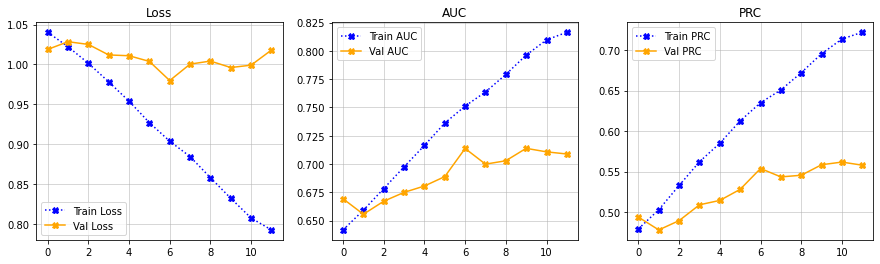

In [34]:
plot_metrics(history)

In [36]:
from tensorflow.keras.models import load_model
my_model = load_model(Hdf5_file[-1])

In [39]:
predictions = my_model.predict(image_test_array)

14/14 [==============================] - 11s 666ms/step


In [40]:
predictions.shape

(437, 3)

In [41]:
ypred = []
for prediction in predictions:
  ypred.append(prediction.argmax())

In [42]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(
    label_test_array,
    ypred
)

In [43]:
conf_matrix

array([[ 66,  73,   0],
       [ 39, 165,   0],
       [ 25,  68,   1]])

In [44]:
cm_df = pd.DataFrame(conf_matrix,
                     index = ['CN','MCI','AD'], 
                     columns = ['CN','MCI','AD'])

In [45]:
cm_df

,CN,MCI,AD
CN,66,73,0
MCI,39,165,0
AD,25,68,1


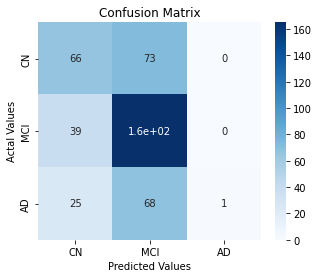

In [47]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

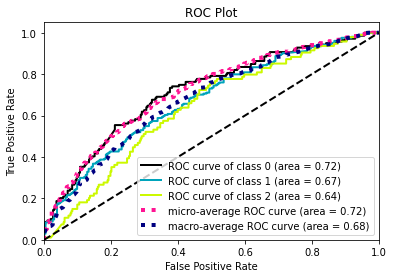

In [51]:
skplt.metrics.plot_roc(label_test_array, predictions, title = 'ROC Plot');

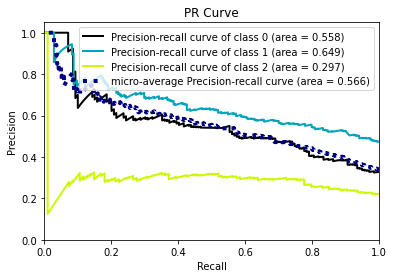

In [52]:
skplt.metrics.plot_precision_recall(label_test_array, predictions, title = 'PR Curve');

In [53]:
target_names = ['CN', 'MCI', 'AD']
print(classification_report(label_test_array, ypred, target_names=target_names))

              precision    recall  f1-score   support

          CN       0.51      0.47      0.49       139
         MCI       0.54      0.81      0.65       204
          AD       1.00      0.01      0.02        94

    accuracy                           0.53       437
   macro avg       0.68      0.43      0.39       437
weighted avg       0.63      0.53      0.46       437

